In [8]:
import SimpleITK as sitk
# from downloaddata import fetch_data as fdata
%matplotlib inline
from extensies import gui
from extensies import registration_gui as rgui
from extensies import preprocessing as ppcs
from extensies import normalization
from siamese.dataset import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from extensies import metrics as mt
import os
import re 
OUTPUT_DIR = 'output'

In [2]:
df_images = pd.read_csv('../../data/info/ProstateX-Images-Train.csv')
df_findings = pd.read_csv('../../data/info/ProstateX-Findings-Train.csv')
df_ktrans = pd.read_csv('../../data/info/ProstateX-Images-KTrans-Train.csv')

In [3]:
def show_images(fixed_image,moving_image,name,findings):
    pos = findings[findings['ProxID'] == name]['pos']
    for x in pos:
        center = [float(x) for x in x.split()] 
        print(fixed_image.TransformPhysicalPointToContinuousIndex(center),
             moving_image.TransformPhysicalPointToContinuousIndex(center))
        
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

    gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=initial_transform)

In [4]:
def load_images(name):

    fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(ppcs.get_path(name, 't2tsetra', '../../data/PROSTATEx'))
    moving_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(ppcs.get_path(name, 'adc', '../../data/PROSTATEx'))

    t2w_image = sitk.ReadImage(fixed_series_filenames, sitk.sitkFloat32)
    adc_image = sitk.ReadImage(moving_series_filenames, sitk.sitkFloat32)
    ktrans_image = sitk.ReadImage(os.path.join('../../data/','Ktrans',name,name +'-Ktrans.mhd'), sitk.sitkFloat32)
    
    return t2w_image,adc_image,ktrans_image

In [5]:
df_findings.loc[155]

ProxID              ProstateX-0106
fid                              1
pos        11.6356 42.7856 21.9458
zone                            PZ
ClinSig                      False
Name: 155, dtype: object

In [6]:
df_findings = df_findings.drop(154)

(149.2640471782723, 187.83000569080127, 10.999990688772572) (50.2546666537226, 63.110025452104644, 9.714294334823336)
(201.71304717015514, 227.4060683872062, 7.9999911941967605) (67.73766665101688, 76.3020478162715, 7.142864188649924)
(221.18204717513012, 203.15001236796596, 5.999993964341351) (74.22733331934188, 68.21669688278959, 5.428577652839075)


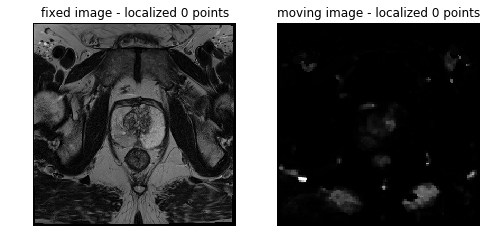

In [14]:
name = 'ProstateX-0040'

t2w_image,adc_image,ktrans_image = load_images(name)
show_images(t2w_image, ktrans_image, name, df_findings)

# Patch with lesion in diferent MRI modalities

In [15]:
modalities = ['t2tsetra/t/40x40x1/', 'adc/t/40x40x1/', 'ktrans/t/40x40x1/']
loader = DataLoader('../../data/',modalities)
loader.load_data()
X,y = loader.get_data('t2tsetra/t/40x40x1/')

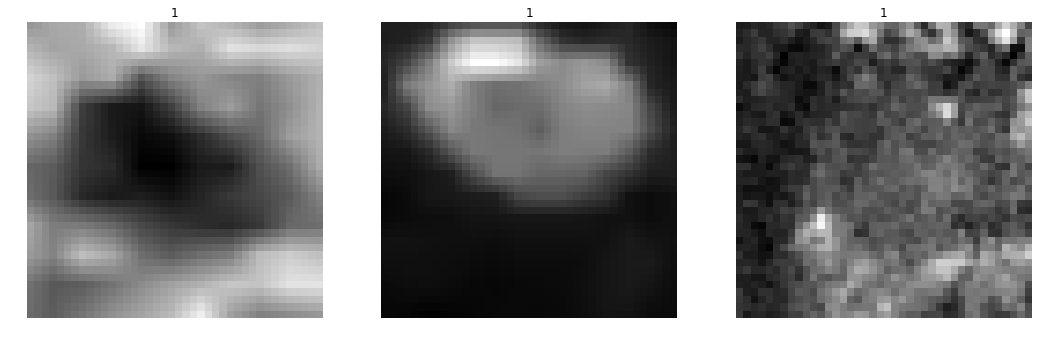

In [19]:
x,y = loader.get_data_by_index(idx = 20)
mt.show_image(np.array([0,1,2]),x,y)

In [20]:
histograms = [None] * len(x)
for idx,volume in enumerate(x):
    volume = volume[volume > 0]
    hist = np.histogram(volume,100)[0]
    histograms[idx] = hist
histograms = np.array(histograms)

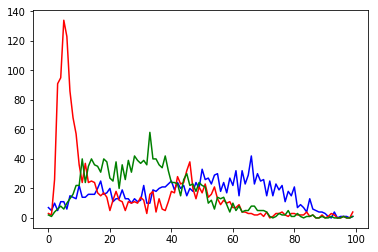

In [21]:
plt.plot(np.arange(100),histograms[0], 'b')
plt.plot(np.arange(100),histograms[1], 'r')
plt.plot(np.arange(100),histograms[2], 'g')